1.	Provide a solution which will help the operations team to manage cash loading of the ATMs
2.	Forecast/predict dispense amount for each ATM for next 7 days
3.	Create basic visualizations for highlighting key insights from the data
4.	You can use external data if available and if it helps improve the accuracy of the model
5.	Define metric used to measure model accuracy and why did you use it
6.	Share your solution in the form of Jupyter Notebook file / PPT. Formatting/animation in the PPT does not matter much here. Focus on the forecasts and key insights from the data.  
7.	Write your code in Python language.
8.	Mention all the assumptions you have taken into account in the solution file.


### Assumptions
Dispense trends are influenced by historical patterns (no significant external disruptions).
ATM downtime (DT) and transaction count (CountTotalTxn) correlate with dispense.
External events (like holidays or salary dates) can be modeled using public data.

India holidays external data used refrence link: https://www.timeanddate.com/holidays/india/2021

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from pandas.tseries.offsets import DateOffset

In [2]:
df=pd.read_excel("D:\\Desktop\\files\\Case Study\\data_raw.xlsx")


In [3]:
HDs=pd.read_excel("D:\\Desktop\\files\\Case Study\\data_raw.xlsx", sheet_name="holidays")

In [4]:
df.head()

,Account,ATMID',caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364


In [5]:
HDs.head()

,Date,Weekdays,Name,Type
0,2021-01-01,Friday,New Year's Day,Restricted Holiday
1,2021-01-13,Wednesday,Lohri,Restricted Holiday
2,2021-01-14,Thursday,Pongal,Restricted Holiday
3,2021-01-14,Thursday,Makar Sankranti,Restricted Holiday
4,2021-01-20,Wednesday,Guru Govind Singh Jayanti,Restricted Holiday


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14593 entries, 0 to 14592
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Account           14593 non-null  object        
 1   ATMID'            14593 non-null  object        
 2   caldate           14593 non-null  datetime64[ns]
 3   Dispense          14593 non-null  int64         
 4   DT                14593 non-null  int64         
 5   MaxCapacity       14593 non-null  int64         
 6   CountTotalTxn     14593 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 798.2+ KB


In [7]:
df.describe()

,Dispense,DT,MaxCapacity,CountTotalTxn
count,1.459300e+04,14593.000000,1.459300e+04,14593.000000
mean,4.027993e+05,158.538614,3.279753e+06,105.322963
std,3.036762e+05,356.073765,3.974770e+05,76.727151
min,0.000000e+00,0.000000,2.420000e+06,0.000000
25%,1.685000e+05,0.000000,2.860000e+06,45.000000
50%,3.653000e+05,0.000000,3.520000e+06,98.000000
75%,5.780000e+05,64.000000,3.520000e+06,146.000000
max,2.151800e+06,1440.000000,3.740000e+06,561.000000


In [8]:
# Cleaning column names
def Clean_name(col):
    return col.strip().lower().replace("'", '').replace('_', '').replace(' ', '').replace('-', '')

df.columns = [Clean_name(col) for col in df.columns]

In [9]:
df.head()

,account,atmid,caldate,dispense,dt,maxcapacity,counttotaltxn
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364


In [10]:
# Convert 'caldate' to datetime
df['caldate'] = pd.to_datetime(df['caldate'])
df.head()

,account,atmid,caldate,dispense,dt,maxcapacity,counttotaltxn
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364


In [11]:
# Add columns for Year, Month, and Day of Week
df['Year'] = df['caldate'].dt.year
df['Month'] = df['caldate'].dt.month
df['DayOfWeek'] = df['caldate'].dt.dayofweek
df.head()

,account,atmid,caldate,dispense,dt,maxcapacity,counttotaltxn,Year,Month,DayOfWeek
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157,2021,1,4
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92,2021,1,4
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36,2021,1,4
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101,2021,1,4
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364,2021,1,4


In [12]:
# Calculate the week of the year
df['WeekOfYear'] = df['caldate'].dt.isocalendar().week

# Concatenate year and week to create a unique identifier
df['YearWeek'] = df['caldate'].dt.strftime('%Y') + '-W' + df['WeekOfYear'].astype(str)

# Group by year-week and sum the dispense amounts (if needed)
weekly_dispense = df.groupby('YearWeek')['dispense'].mean().reset_index()



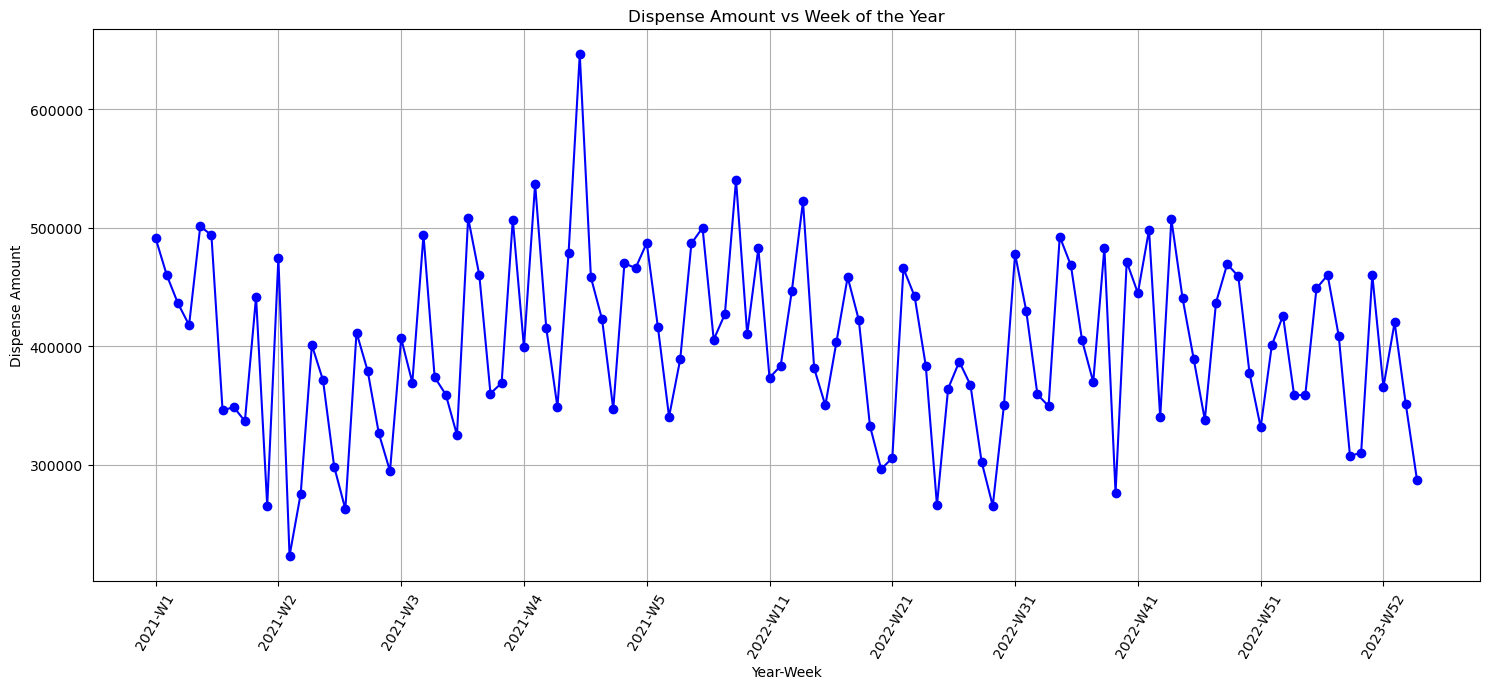

In [13]:
# Plotting
plt.figure(figsize=(15, 7))  # Increased figure size
plt.plot(weekly_dispense['YearWeek'], weekly_dispense['dispense'], marker='o', linestyle='-', color='b')
plt.title('Dispense Amount vs Week of the Year')
plt.xlabel('Year-Week')
plt.ylabel('Dispense Amount')

# Adjust x-axis ticks
plt.xticks(ticks=range(0, len(weekly_dispense['YearWeek']), max(1, len(weekly_dispense['YearWeek']) // 10)), 
           labels=weekly_dispense['YearWeek'][::max(1, len(weekly_dispense['YearWeek']) // 10)], 
           rotation=60)

plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Aggregating dispense by Year and Month
monthly_trends = df.groupby(['Year', 'Month'])['dispense'].sum().reset_index()
monthly_trends.head()

,Year,Month,dispense
0,2021,1,194029700
1,2021,2,178336900
2,2021,3,197845500
3,2021,4,173957300
4,2021,5,135041600


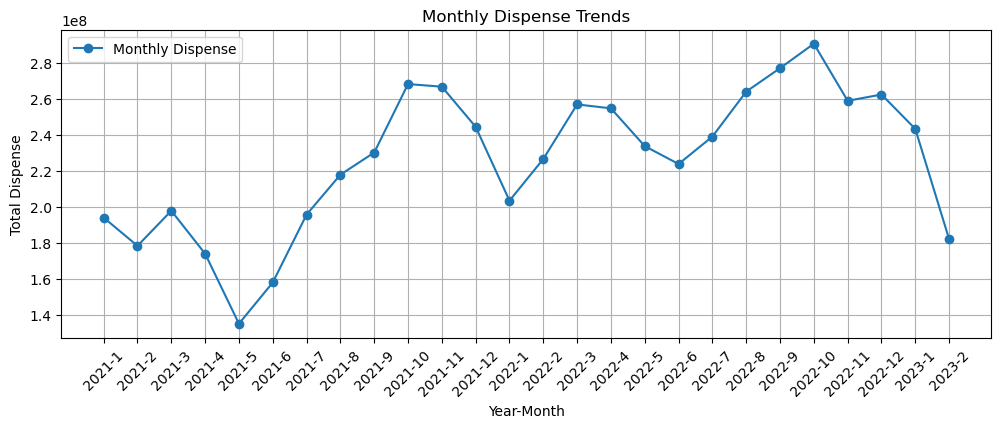

In [15]:
import matplotlib.pyplot as plt

# Create a 'Year-Month' column for better visualization
monthly_trends['YearMonth'] = monthly_trends['Year'].astype(str) + "-" + monthly_trends['Month'].astype(str)

# Plot the trend
plt.figure(figsize=(12, 4))
plt.plot(monthly_trends['YearMonth'], monthly_trends['dispense'], marker='o', label='Monthly Dispense')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Monthly Dispense Trends")
plt.xlabel("Year-Month")
plt.ylabel("Total Dispense")
plt.legend()
plt.grid()
plt.show()


#### Impact of Downtime across each ATMs

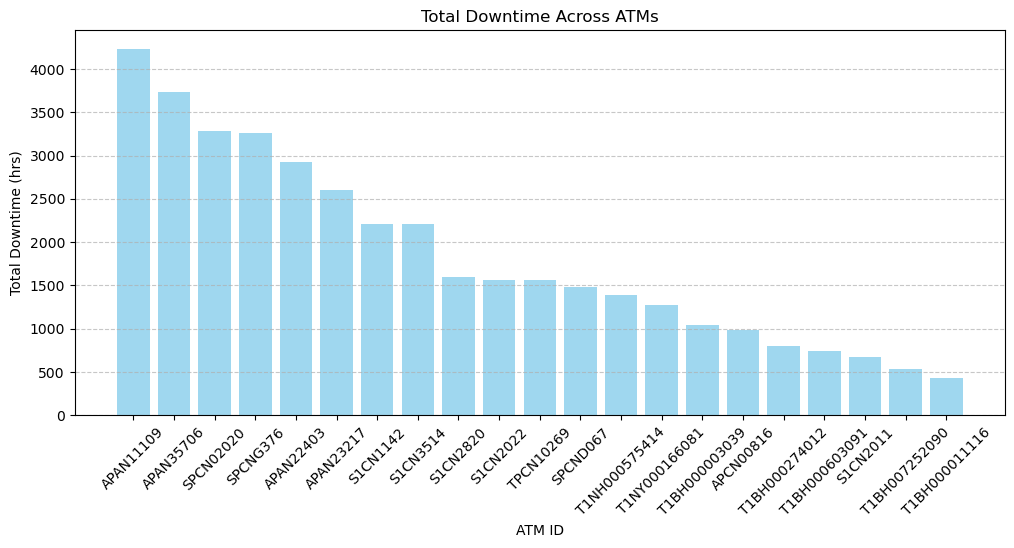

In [16]:
# Group by ATMID to calculate total downtime
downtime_by_atm = df.groupby('atmid')['dt'].sum().reset_index()

# Sort by downtime for better visualization
downtime_by_atm = downtime_by_atm.sort_values(by='dt', ascending=False)

# Plotting the total downtime
plt.figure(figsize=(12, 5))
plt.bar(downtime_by_atm['atmid'], downtime_by_atm['dt']/60, color='skyblue', alpha=0.8)
plt.title("Total Downtime Across ATMs")
plt.xlabel("ATM ID")
plt.ylabel("Total Downtime (hrs)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:
# Checking downtime in particular day of week
downtime_by_day = df.groupby(df['caldate'].dt.dayofweek)['dt'].sum().reset_index()
downtime_by_day.columns = ['DayOfWeek', 'TotalDowntime']
downtime_by_day

,DayOfWeek,TotalDowntime
0,0,374114
1,1,332020
2,2,321303
3,3,300403
4,4,325133
5,5,316839
6,6,343742


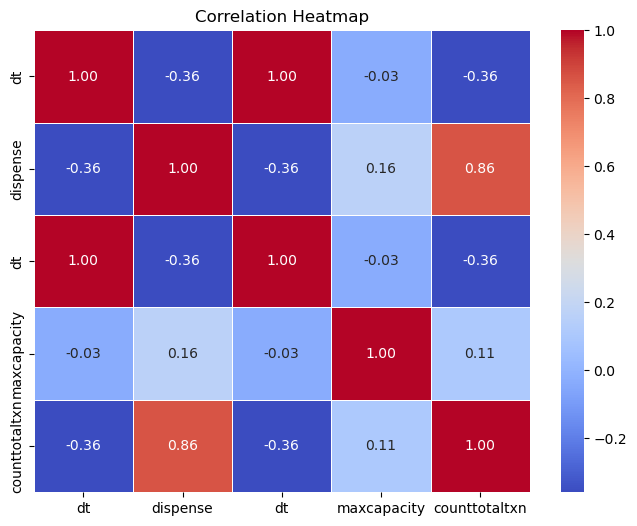

In [18]:
# Checking corelations
downtime_dispense_corr = df[['dt', 'dispense','dt','maxcapacity','counttotaltxn']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(downtime_dispense_corr,annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
# Using Clustering technique
atm_downtime = df.groupby('atmid')['dt'].sum().reset_index()
kmeans = KMeans(n_clusters=3, random_state=42).fit(atm_downtime[['dt']])
atm_downtime['Cluster'] = kmeans.labels_
atm_downtime.head()

NameError: name 'KMeans' is not defined

In [ ]:
# Assign colors to clusters for visualization
cluster_colors = ['red', 'green', 'blue']  # One color per cluster

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for cluster in atm_downtime['Cluster'].unique():
    cluster_data = atm_downtime[atm_downtime['Cluster'] == cluster]
    plt.scatter(cluster_data['atmid'], cluster_data['dt'], 
                label=f'Cluster {cluster}', 
                color=cluster_colors[cluster], alpha=0.7)

# Add plot details
plt.title("ATM Downtime Clusters")
plt.xlabel("ATM ID")
plt.ylabel("Total Downtime (minutes)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Action: 

1) Prioritize maintenance for ATMs with the highest downtime.
2) Schedule maintenance or upgrades during non-peak hours on Moday.
3) Based on Cluster grapgh develop targeted maintenance strategies for each group.
4) Minimize downtime for high-transaction ATMs.

In [ ]:
# Calculate total transaction volume per ATM
transaction_volume = df.groupby('atmid')['counttotaltxn'].sum().reset_index()

# Rename columns for clarity
transaction_volume.rename(columns={'counttotaltxn': 'TotalTransactions'}, inplace=True)

# Sort by transaction volume
transaction_volume.sort_values(by='TotalTransactions', ascending=False, inplace=True)

# Display the results
plt.figure(figsize=(12, 5))
plt.bar(transaction_volume['atmid'],transaction_volume['TotalTransactions'])
plt.title("Total Transactions")
plt.xlabel("ATM ID")
plt.ylabel("Total Transactions count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Insights:

##### High Transaction Volume ATMs:
Identify ATMs with the most activity and prioritize maintenance and cash loading for them.

##### Low Transaction Volume ATMs:
Investigate low-usage ATMs to determine if they are in underutilized locations.

In [ ]:
# Aggregating dispense by Day of Week
weekly_trends = df.groupby('DayOfWeek')['dispense'].mean().reset_index()
weekly_trends.head()

### Data Prepration for Model Building

In [ ]:
# Pivot data for time-series analysis
time_series_data = df.pivot_table(index='caldate', columns='atmid', values='dispense', aggfunc='sum').fillna(0)


In [ ]:
# Splitting into training and testing data
train_data = time_series_data[:-20]
test_data = time_series_data[-20:]

In [ ]:
train_data.head()


In [ ]:
# Function to forecast using ARIMA
def forecast_arima(train, test, order=(5, 1, 0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    return predictions

In [ ]:
# Forecasting for one ATM (first ATM column)
atm_id = time_series_data.columns[0]
train_atm = train_data[atm_id]
test_atm = test_data[atm_id]

predictions = forecast_arima(train_atm, test_atm)

In [ ]:
# Forecasting for one ATM on test data set (first ATM column)
atm_id = time_series_data.columns[0]
train_atm = train_data[atm_id]
test_atm = test_data[atm_id]

predictions = forecast_arima(train_atm, test_atm)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_atm, predictions))
print("RMSE:", rmse)
print("Next 7-Day Predictions:", predictions[:7])

#### Statistical  Analysis

#### The RMSE is the square root of the average squared differences between predicted and actual values

Sensitive to Large Errors:

Squaring the differences amplifies the effect of larger errors, making RMSE particularly suitable for identifying models that tend to produce significant deviations in predictions (e.g., under-predicting or over-predicting dispense amounts).
Same Scale as the Data:

The RMSE is measured in the same units as the target variable (₹ for ATM dispense amounts), making it interpretable and relevant for practical decision-making.
Focus on Magnitude of Errors:

Since ATM operations involve penalties for both cash-outs (insufficient cash) and idle cash holding (excess cash), minimizing large errors is crucial. RMSE emphasizes this by penalizing large deviations more heavily than metrics like Mean Absolute Error (MAE).
Ease of Comparison:

RMSE is a widely used metric in forecasting tasks, making it easy to compare the performance of our ARIMA-based model with alternative models in future iterations.


In [ ]:
# Create a dictionary to store min and max values for each ATMID
atm_stats = {}

# Calculate min and max for each ATMID in the test data
for atm_id in test_data.columns:
    min_dispense = test_data[atm_id].min()
    max_dispense = test_data[atm_id].max()
    atm_stats[atm_id] = {
        "Minimum Dispense Value": min_dispense,
        "Maximum Dispense Value": max_dispense,
    }

# Convert to a DataFrame
atm_stats_df = pd.DataFrame.from_dict(atm_stats, orient="index")
atm_stats_df.reset_index(inplace=True)
atm_stats_df.rename(columns={"index": "ATMID"}, inplace=True)
print("Min/Max Values for Each ATMID:")
atm_stats_df.head()


In [ ]:
# Merge atm_stats_df and rmse_df on ATMID
merged_df = pd.merge(atm_stats_df, rmse_df, on="ATMID")

# Calculate RMSE Proportion (%) and handle cases where max value is 0
merged_df["RMSE Proportion (%)"] = (merged_df["RMSE"] / merged_df["Maximum Dispense Value"]) * 100
merged_df["RMSE Proportion (%)"] = merged_df["RMSE Proportion (%)"].fillna(0)  # Replace NaN with 0 for safety
# Sort the DataFrame by the 'RMSE Proportion (%)' column in descending order
sorted_df = merged_df.sort_values(by='RMSE Proportion (%)', ascending=False)


In [ ]:
sorted_df.head(10)

##### Proportion Meaning: 
RMSE Proportion measures the relative error compared to the maximum capacity of an ATM. Lower proportions indicate better model performance for that ATM.

##### High Proportion (e.g., APAN35706 at 47.03%): 
Indicates that the prediction error is high compared to the ATM's capacity. For such ATMs, you may need to:

Analyze outliers or sudden trends in dispense amounts.
Incorporate external factors like holidays or local demand variations.
Test alternative forecasting models or techniques.

##### Low Proportion (e.g., S1CN2022 at 25.12%):
Indicates that the predictions are relatively accurate and well-suited to the ATM's dispense pattern.

##### Threshold for Good Proportions: 
Ideally, RMSE proportions below 30-40% can be considered acceptable in this context, as they represent manageable errors relative to the ATM's capacity.

In [ ]:
# Combine last 15 days of actual data and 7 days of predictions
plot_data = test_atm[-15:].append(pd.Series(predictions[:7], index=test_atm.index[-7:]))

# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(test_atm[-15:].index, test_atm[-15:], label="Actual (Last 15 Days)", marker='o')
plt.plot(test_atm.index[-7:], predictions[:7], label="Predicted (Next 7 Days)", marker='o', linestyle='--')

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Dispense Amount")
plt.title(f"ATM Dispense: Last 15 Days Actual vs Next 7 Days Predictions (ATM: {atm_id})")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### Plotting 7 Days Predictions vs 15 Days Test Data

In [ ]:
# Loop through all ATMIDs to generate plots
for atm_id, result in results.items():
    # Extract data for the current ATM
    actual_last_15 = result['Actual_Test']
    predictions_next_7 = result['Predictions']
    
    # Combine last 15 days actual data with next 7 days predictions
    plot_data = actual_last_15.append(
        pd.Series(predictions_next_7, index=actual_last_15.index[-7:])
    )
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(actual_last_15.index, actual_last_15, label="Actual (Last 15 Days)", marker='o')
    plt.plot(
        actual_last_15.index[-7:], predictions_next_7, label="Predicted (Next 7 Days)", marker='o', linestyle='--'
    )
    
    # Add labels, title, and legend
    plt.xlabel("Date")
    plt.ylabel("Dispense Amount")
    plt.title(f"ATM Dispense: Last 15 Days Actual vs Next 7 Days Predictions (ATM: {atm_id})")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:


# Initialize a dictionary to store results
future_forecasts = {}

# Loop through all ATMIDs
for atm_id in time_series_data.columns:
    print(f"Forecasting next 7 days for ATM: {atm_id}")
    
    # Extract train data for the ATM
    train_atm = train_data[atm_id]
    
    try:
        # Fit the ARIMA model
        model = ARIMA(train_atm, order=(5, 1, 0))
        model_fit = model.fit()
        
        # Forecast next 7 days
        forecast_values = model_fit.forecast(steps=7)
        
        # Generate future dates
        last_date = train_atm.index[-1]
        future_dates = [last_date + DateOffset(days=i) for i in range(1, 8)]
        
        # Store results
        future_forecasts[atm_id] = {
            "Forecasted_Dates": future_dates,
            "Forecasted_Values": forecast_values
        }
        
        # Plot actual and forecasted values
        plt.figure(figsize=(12, 5))
        plt.plot(train_atm.index[-15:], train_atm[-15:], label="Actual (Last 15 Days)", marker='o')
        plt.plot(future_dates, forecast_values, label="Predicted (Next 7 Days)", marker='o', linestyle='--')
        
        # Add labels, title, and legend
        plt.xlabel("Date")
        plt.ylabel("Dispense Amount")
        plt.title(f"ATM Dispense: Next 7 Days Forecast (ATM: {atm_id})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        
        # Show the plot
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error forecasting for ATM {atm_id}: {e}")


### Future works

1) This problem can we converted into regression problem based on average weekly dipense amount will be target variable.
2) All further analysis can be done based on weekly basis.
3) Prediction will give one avreage weekly number it can be easy for operation team to take desicion based on same, with plus and minus ranges.